<a href="https://colab.research.google.com/github/fseidl-gdit/tutorial_binder/blob/main/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
import pandas_gbq
import pandas as pd
import numpy
import seaborn
from google.cloud import bigquery
from google.oauth2 import service_account
%load_ext rpy2.ipython


bq_project='isb-cgc-etl'
auth.authenticate_user()
client = bigquery.Client(project=bq_project)
print('Authenticated')

Authenticated


In [ ]:
#credentials = service_account.Credentials.from_service_account_file(
#    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"])
#client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [ ]:
%%R
install.packages('bigrquery')
library(bigrquery)
library(repr)

# Clinical and cohort queries
How old are the patients for each case in a given project?

In [3]:
%%R
project <- "isb-cgc-etl"

case_sql <- "select
  submitter_id case_barcode,
  demo__age_at_index age,
  demo__vital_status vital
from `isb-cgc-bq.TCGA.clinical_gdc_current`
where proj__project_id = 'TCGA-BRCA'
"
case_query <- bq_project_query(project, query=case_sql)
case_df <- as.data.frame(bq_table_download(case_query))
head(case_df)

R[write to console]: Complete

R[write to console]: Billed: 0 B

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



  case_barcode age vital
1 TCGA-A8-A07E  81 Alive
2 TCGA-A8-A099  76 Alive
3 TCGA-A8-A09A  40 Alive
4 TCGA-A8-A09C  69 Alive
5 TCGA-B6-A0I8  46  Dead
6 TCGA-B6-A0RE  61 Alive


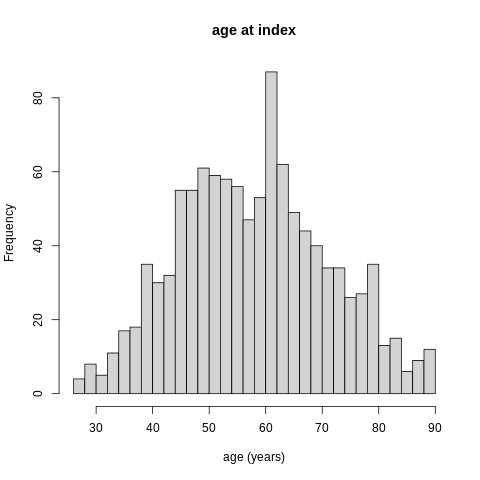

In [4]:
%%R
case_num <- length(unique(case_df[,2]))
hist(case_df[,2], breaks=case_num/2, main='age at index', xlab='age (years)')

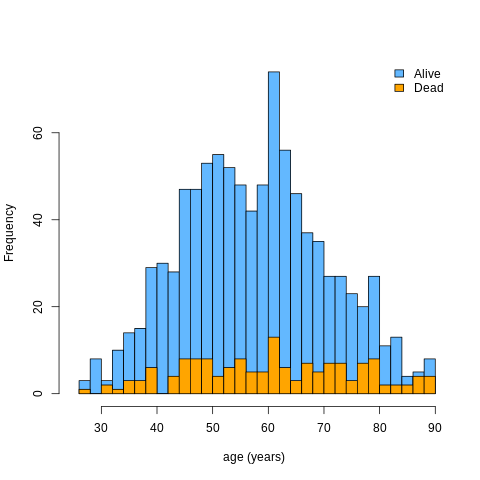

In [5]:
%%R
hist(case_df[case_df[,3] == 'Alive',2], breaks=case_num/2, xlim=c(25,90), col='steelblue1', main='', xlab='age (years)')
hist(case_df[case_df[,3] == 'Dead',2], breaks=case_num/2, add=1, col='orange')
legend('topright', bty='n', legend=c('Alive', 'Dead'), fill=c('steelblue1', 'orange'))

# Gene expressionn
What is the mean RNAseq expression (fpkm-uq) of a specific gene in normal and tumor?

Table: *isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current*

In [53]:
%%R
expr_sql <- "select
  case_barcode,
  aliquot_barcode,
  sample_type_name,
  avg(HTSeq__FPKM_UQ) avg_fpkm
from `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
where project_short_name = 'TCGA-BRCA'
and gene_name = 'CCNB1'
group by case_barcode, aliquot_barcode, sample_type_name"

expr_query <- bq_project_query(project, query=expr_sql)
expr_df <- bq_table_download(expr_query)
head(expr_df)

R[write to console]: Complete

R[write to console]: Billed: 59.85 GB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 4
  case_barcode aliquot_barcode              sample_type_name avg_fpkm
  <chr>        <chr>                        <chr>               <dbl>
1 TCGA-AO-A0JE TCGA-AO-A0JE-01A-11R-A056-07 Primary Tumor     508281.
2 TCGA-AN-A0FT TCGA-AN-A0FT-01A-11R-A034-07 Primary Tumor     136998.
3 TCGA-C8-A3M7 TCGA-C8-A3M7-01A-12R-A21T-07 Primary Tumor     326013.
4 TCGA-A2-A0CU TCGA-A2-A0CU-01A-12R-A034-07 Primary Tumor     476361.
5 TCGA-A2-A0YH TCGA-A2-A0YH-01A-11R-A109-07 Primary Tumor     664528.
6 TCGA-E2-A1AZ TCGA-E2-A1AZ-01A-11R-A12P-07 Primary Tumor    1140135.


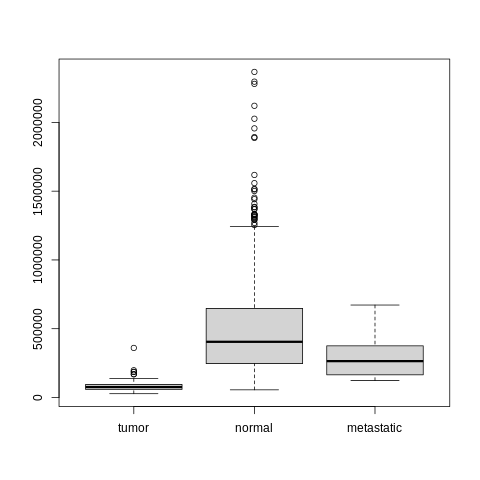

In [55]:
%%R

tumor <- unlist(expr_df[expr_df[,3] == 'Primary Tumor',4])
normal <- unlist(expr_df[expr_df[,3] == 'Solid Tissue Normal',4])
metastatic <- unlist(expr_df[expr_df[,3] == 'Metastatic',4])

boxplot(list(normal, tumor, metastatic), names=c('tumor', 'normal', 'metastatic'))

We can also generate summary statistics directly in BigQuery.

In [29]:
%%R
summ_sql <- "select
  sample_type_name,
  avg(HTSeq__FPKM_UQ) avg_fpkm,
  stddev(HTSeq__FPKM_UQ) sdv_fpkm,
  max(HTSeq__FPKM_UQ) max_fpkm,
  min(HTSeq__FPKM_UQ) min_fpkm
from `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
where project_short_name = 'TCGA-BRCA'
and gene_name = 'CCNB1'
group by sample_type_name"

summ_query <- bq_project_query(project, query=summ_sql)
summ_df <- bq_table_download(summ_query)
head(summ_df)

R[write to console]: Complete

R[write to console]: Billed: 30.33 GB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 3 × 5
  sample_type_name    avg_fpkm sdv_fpkm max_fpkm min_fpkm
  <chr>                  <dbl>    <dbl>    <dbl>    <dbl>
1 Metastatic           305474.  193940.  671952.  122495.
2 Solid Tissue Normal   83936.   42956.  360053.   27282.
3 Primary Tumor        487856.  330627. 2367487.   55187.


#Genome annotation
We can retrieve Gencode annotation data for specific genes from BigQuery tables

Table: *isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22*

In [36]:
%%R
annot_sql <- "select * from `isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22` where gene_name = 'CCNB1' and transcript_name = 'CCNB1-001'"

annot_query <- bq_project_query(project, query=annot_sql)
annot_df <- bq_table_download(annot_query)
print(annot_df)

R[write to console]: Complete

R[write to console]: Billed: 947.91 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 23 × 32
   seq_name source feature        start      end frame strand gene_name gene_id 
   <chr>    <chr>  <chr>          <int>    <int> <chr> <chr>  <chr>     <chr>   
 1 chr5     HAVANA CDS         69171270 69171452 .     +      CCNB1     ENSG000…
 2 chr5     HAVANA CDS         69174877 69175113 .     +      CCNB1     ENSG000…
 3 chr5     HAVANA start_codon 69167263 69167265 .     +      CCNB1     ENSG000…
 4 chr5     HAVANA exon        69174877 69175113 .     +      CCNB1     ENSG000…
 5 chr5     HAVANA UTR         69167010 69167262 .     +      CCNB1     ENSG000…
 6 chr5     HAVANA exon        69168173 69168343 .     +      CCNB1     ENSG000…
 7 chr5     HAVANA stop_codon  69177629 69177631 .     +      CCNB1     ENSG000…
 8 chr5     HAVANA exon        69177239 69177349 .     +      CCNB1     ENSG000…
 9 chr5     HAVANA exon        69167010 69167283 .     +      CCNB1     ENSG000…
10 chr5     HAVANA exon        69171270 69171452 .     +      CCNB1     ENSG000…
# … with

# Mutation data
Given the gene annotation data above we can query for mutations within a gene.

Table: *isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current*

In [37]:
%%R
mut_sql <- "select case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
from `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current`
where Chromosome = 'chr5'
    and Start_Position > 69167135
    and End_Position < 69177358"

mut_query <- bq_project_query(project, query=mut_sql)
mut_df <- bq_table_download(mut_query)
head(mut_df)

R[write to console]: Complete

R[write to console]: Billed: 0 B

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 7
  case_barcode Chromosome Start_Position End_Position Reference_Allele
  <chr>        <chr>               <int>        <int> <chr>           
1 TCGA-AP-A059 chr5             69175531     69175531 T               
2 TCGA-06-1805 chr5             69175091     69175091 G               
3 TCGA-13-0751 chr5             69175528     69175529 -               
4 TCGA-B5-A11E chr5             69177254     69177254 C               
5 TCGA-CM-5861 chr5             69174975     69174975 C               
6 TCGA-HT-8012 chr5             69171447     69171447 C               
# … with 2 more variables: Tumor_Seq_Allele1 <chr>, Tumor_Seq_Allele2 <chr>


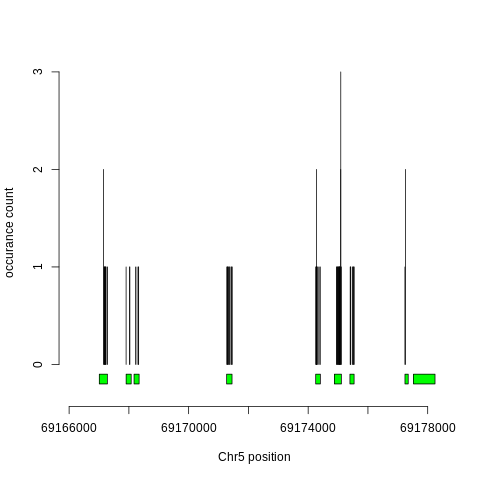

In [52]:
%%R
options(repr.plot.width=10, repr.plot.height=4)
mut_count <- table(mut_df[,3])
max_count <- max(mut_count)
plot(NA, xlim=c(min(mut_df[,3])-1000, max(mut_df[,3])+1000), ylim=c(-0.3,max_count), 
     yaxt='n', bty='n', main='', xlab='Chr5 position', ylab='occurance count')
jnk <- apply(annot_df[annot_df$feature == 'exon',], 1, function(row){
    rect(row[4], -0.2, row[5], -0.1, col='green')
})
axis(2, at=seq(0,3,1))
jnk <- sapply(1:length(mut_count), function(ix){
    x <- as.numeric(names(mut_count)[ix])
    segments(x, 0, x, mut_count[ix])
    })

What about in the 100 kB upstream and downstream of the gene?

In [57]:
%%R
sql <- "select case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
from `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current`
where 
    Chromosome = 'chr9'
    and (
        (Start_Position < 69067135 and Start_Position > 69167135)
        or (End_Position > 69177358 and End_Position < 69277358)
        )"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

R[write to console]: Complete

R[write to console]: Billed: 164.63 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 7
  case_barcode Chromosome Start_Position End_Position Reference_Allele
  <chr>        <chr>               <int>        <int> <chr>           
1 TCGA-G3-A3CG chr9             69254389     69254389 A               
2 TCGA-AA-3672 chr9             69246577     69246577 C               
3 TCGA-D3-A3MU chr9             69236185     69236185 G               
4 TCGA-FX-A2QS chr9             69254215     69254216 -               
5 TCGA-28-1751 chr9             69216447     69216447 G               
6 TCGA-AX-A064 chr9             69237032     69237032 G               
# … with 2 more variables: Tumor_Seq_Allele1 <chr>, Tumor_Seq_Allele2 <chr>


# Table joins
How do we join clinical and mutation data?

Tables: 
*   *isb-cgc-bq.TCGA.clinical_gdc_current*
*   *isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current*




In [58]:
%%R
sql <- "select 
    mut.Chromosome, 
    mut.Start_Position, 
    mut.End_Position, 
    mut.Reference_Allele, 
    mut.Tumor_Seq_Allele1, 
    mut.Tumor_Seq_Allele2, 
    clin.demo__vital_status 
from `isb-cgc-bq.TCGA.clinical_gdc_current` clin
join `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current` mut 
    on clin.submitter_id = mut.case_barcode
where mut.project_short_name = 'TCGA-BRCA'"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

R[write to console]: Complete

R[write to console]: Billed: 204.47 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 7
  Chromosome Start_Position End_Position Reference_Allele    Tumor_Seq_Allele1  
  <chr>               <int>        <int> <chr>               <chr>              
1 chr16            29116153     29116184 AATCTGCTTGCGGTTGGA… AATCTGCTTGCGGTTGGA…
2 chr2            129968224    129968231 AATGTAGA            AATGTAGA           
3 chr2             88801304     88801307 AAGT                AAGT               
4 chr21            18266102     18266135 CAATAGCTTGGAATGGCT… CAATAGCTTGGAATGGCT…
5 chr4             73870648     73870657 AATGTGTTTG          AATGTGTTTG         
6 chr17            73337298     73337308 CTGAGCAAACT         CTGAGCAAACT        
# … with 2 more variables: Tumor_Seq_Allele2 <chr>, demo__vital_status <chr>
